<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/error-analysis/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/cs230 project/dataset/webcam amil.zip' -d dev
! unzip -q '/content/drive/My Drive/cs230 project/dataset/webcam paki.zip' -d dev

In [6]:
# Move 80% of webcam images to the training set
%%bash
source_root='/content/dev/'
target_root='/content/train/'
IFS=$(echo -en "\n\b")
for dir in $(ls -1 "$source_root")
do
    source_dir="$source_root$dir"
    target_dir="$target_root$dir"
    num_files=$(ls -1 "$source_dir" | wc -l)
    num_to_move=$(( $num_files*8/10 ))
    echo "Moving $num_to_move/$num_files files from $source_dir to $target_dir"
    mkdir -p "$target_dir"
    cd "$source_dir"
    ls -1 "$source_dir" | shuf -n $num_to_move | xargs -i mv {} "$target_dir"
 done

Moving 29/37 files from /content/dev/0 angry to /content/train/0 angry
Moving 34/43 files from /content/dev/1 disgust to /content/train/1 disgust
Moving 18/23 files from /content/dev/2 fear to /content/train/2 fear
Moving 22/28 files from /content/dev/3 happy to /content/train/3 happy
Moving 21/27 files from /content/dev/4 sad to /content/train/4 sad
Moving 20/25 files from /content/dev/5 surprise to /content/train/5 surprise
Moving 21/27 files from /content/dev/6 neutral to /content/train/6 neutral


In [0]:
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/test-private.zip' -d dev

In [0]:
def get_datagen(dataset):
    return ImageDataGenerator().flow_from_directory(
              dataset,
              target_size=(48, 48),
              color_mode='grayscale',
              shuffle = True,
              class_mode='categorical',
              batch_size=128)

In [18]:
from skimage import io, transform

X_dev_gen    = get_datagen('/content/dev')

X_dev = np.zeros((len(X_dev_gen.filepaths), 48, 48, 1))
Y_dev = np.zeros((len(X_dev_gen.filepaths), 7))
for i in range(0,len(X_dev_gen.filepaths)):
  x = io.imread(X_dev_gen.filepaths[i], as_gray=True)
  X_dev[i,:] = transform.resize(x, (48,48,1))
  Y_dev[i,X_dev_gen.classes[i]] = 1

Found 3633 images belonging to 7 classes.


In [0]:
model = load_model('/content/drive/My Drive/cs230 project/models/webcam-SGD_LR_0.01000-EPOCHS_50-BS_128-DROPOUT_0.4test_acc_0.588.h5')

In [0]:
# TODO: subtract probabilities?
y_pred = model.predict(X_dev).argmax(axis=1)
y_true = Y_dev.argmax(axis=1)

In [33]:
incorrect = np.count_nonzero(y_pred-y_true)
print("Accuracy on dev images: {:.2%}".format(1.0 - incorrect/len(y_true)))

Accuracy on dev images: 58.82%


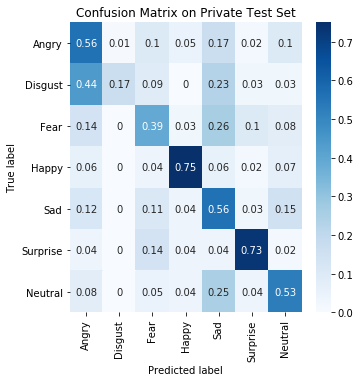

In [34]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Private Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [0]:
# Angry is classified correctly usually, everyone's angry
# Disgust only has 30% correctly, other 30% is angry, but has a high precision
  # use ck+ disgust
# happy, surprise, neutral is predicted well